### DESC Sprint Week ELAsTiCC Tutorial Demo 2

## Reading ELAsTiCC2 Parquet files

This is probably the best general-use format, if you don't already have code that processes SNANA FITS files.

The structure of the Parquet files means that they will tend to work better with Polars dataframes, but you can also use them with Pandas dataframes.  (Both provide a `read_parquet` function.)

On NERSC, the parquet files can be found at `/global/cfs/cdirs/desc-td/ELASTICC2_parquet`

In [1]:
%matplotlib inline

import sys
import math
import os
import pathlib
import logging

import numpy
import polars
import matplotlib
from matplotlib import pyplot

# Need to add the lib_elasticc2 directory to the PYTHONPATH so that we
#  can import it
libdir = pathlib.Path( os.getcwd() ).parent.parent / "lib_elasticc2"
sys.path.insert( 0, str(libdir) )
from read_snana import elasticc2_snana_reader

# Make a logger so that we can print out timings and things like that
_logger = logging.getLogger("main")
if not _logger.hasHandlers():
    _logout = logging.StreamHandler( sys.stderr )
    _logger.addHandler( _logout )
    _logout.setFormatter( logging.Formatter( f'[%(asctime)s - %(levelname)s] - %(message)s',
                                             datefmt='%Y-%m-%d %H:%M:%S' ) )
_logger.setLevel( logging.INFO )
_logger.info( "Testing" )

# Make a random number generator.  If you 
#  want reproducibility, set the seed
#  to something other than None.
# _random_seed = None
_random_seed = 42
rng = numpy.random.default_rng( seed=_random_seed )

PHOTFLAG_DETECT = 0x1000
PHOTFLAG_TRIGGER = 0x0800
PHOTFLAG_SATURATE = 0x0400

[2024-10-30 10:00:10 - INFO] - Testing


In [2]:
# Define a function for plotting lightcurves.  We're going to use
# this lots below, and this saves repeated code in cells
#
# This version of plot_ltcv expects Polars serieses for mjd, band, flux, and fluxerr
def plot_ltcv( mjd, band, flux, fluxerr, snid=None, zcmb=None, mjdoff=0, figsize=None, width=None, multiplots=False ):
    plotcolors = { 'u': '#cc0ccc', 
                   'g': '#00cc44', 
                   'r': '#cc0000', 
                   'i': '#ff4400', 
                   'z': '#886600',
                   'Y': '#442200' }
    knownbands = band.unique()
    if any( b not in plotcolors.keys() for b in knownbands ):
        _logger.warning( f"Unknown bands not plotted: {[b for b in knownbands if b not in plotcolors.keys()]}" )
    bandstoplot = [ b for b in plotcolors.keys() if b in knownbands ]
    
    if multiplots:
        nrows = math.ceil( len(bandstoplot) / 2 )
        if figsize is None:
            width = 9 if width is None else width
            figsize = ( width, width/3. * nrows )
        fig, axes = pyplot.subplots( nrows, 2, figsize=figsize, tight_layout=True, sharex='all' )
        axes = axes.flatten()
    else:
        if figsize is None:
            width = 9 if width is None else width
            figsize = ( width, width/2. )
        fig, axes = pyplot.subplots( 1, 1, figsize=figsize, tight_layout=True )
        axes = [ axes ]
    axesdex = 0
    
    for curband in bandstoplot:
        inband = ( band == curband )
        axes[axesdex].errorbar( mjd.filter(inband)-mjdoff, flux.filter(inband), yerr=fluxerr.filter(inband),
                                color=plotcolors[curband], linestyle='None', marker='o',
                                label=curband )
        if multiplots: axesdex += 1

    for i, axis in enumerate(axes):
        if i >= len(bandstoplot):
            axis.set_visible( False )
        else:
            title = ""
            if snid is not None: title += f"SN {snid}"
            if zcmb is not None: title += f"{' at ' if snid is not None else ''} z={zcmb:.3f}"
            if len(title) > 0: axis.set_title( title )
            if mjdoff != 0:
                axis.set_xlabel( f"MJD-{mjdoff}" )
            else:
                axis.set_xlabel( r"MJD" )
            axis.set_ylabel( r"Flux" )
            axis.tick_params( axis='both', reset=True )
            axis.legend()

    # In the jupyter script environment, the plot gets shown
    #   inline automatically.  If you're running this
    #   from the command line, you might need to do
    #   fig.show().  You might also want to do something
    #   like fig.savefig(filename).  So, return the Figure
    #   to make these things possible.
    # One side-effect of this is that your figure may be
    #   shown *twice* in your jupyter notebook; once for
    #   the plotting above, and once again if the call
    #   to plot_ltcv is the last command in the cell,
    #   because jupyter by default displays the value
    #   of the last expression in each cell.  Add a ;
    #   to the end of your plot_ltcv cell to supporess
    #   this in jupyter.
    return fig


In [5]:
# Read one of the parquet files into a polars data frame.
# For a large model, this will take a long time (~0.5-3 minutes),
# though not nearly as long as it would take to read all of
# the gzipped SNANA FITS files for a single large model.

pqfile = ( pathlib.Path(os.getenv("TD", "/global/cfs/cdirs/lsst/groups/TD"))
           / "ELASTICC2_parquet/SNIa-SALT3.parquet" )
_logger.info( f"Reading {pqfile}..." )
sniadf = polars.read_parquet( pqfile )
_logger.info( f"...done reading {pqfile.name}; the polars dataframe uses ~{sniadf.estimated_size('gb'):.3f} GB of memory." )

[2024-10-30 10:03:20 - INFO] - Reading /global/cfs/cdirs/lsst/groups/TD/ELASTICC2_parquet/SNIa-SALT3.parquet...
[2024-10-30 10:03:44 - INFO] - ...done reading SNIa-SALT3.parquet; the polars dataframe uses ~20.452 GB of memory.


In [4]:
# The structure of one of these Polars data frames is different from
# that of a Pandas data frame (or even a Polars data frame) read with
# the elasticc2_snana_reader library.  There are two primary differences.
# First, there are many columns, including a lot of the object truth
# data.  (The object truth data is mostly in the "SIM_*" columns, such
# as SIM_REDSHIFT_CMB.)  Second, lightcurves are included as list columns.
# Pandas doesn't really like you to use this kind of structure; Polars
# has more built-in support for columns whose elements are lists.

sniadf[0:5]

SNID,MJD,BAND,PHOTFLAG,PHOTPROB,FLUXCAL,FLUXCALERR,PSF_SIG1,SKY_SIG,RDNOISE,ZEROPT,ZEROPT_ERR,GAIN,SIM_MAGOBS,RA,DEC,SNTYPE,NOBS,PTROBS_MIN,PTROBS_MAX,MWEBV,MWEBV_ERR,REDSHIFT_HELIO,REDSHIFT_HELIO_ERR,REDSHIFT_FINAL,REDSHIFT_FINAL_ERR,VPEC,VPEC_ERR,HOSTGAL_NMATCH,HOSTGAL_NMATCH2,HOSTGAL_OBJID,HOSTGAL_FLAG,HOSTGAL_PHOTOZ,HOSTGAL_PHOTOZ_ERR,HOSTGAL_SPECZ,HOSTGAL_SPECZ_ERR,HOSTGAL_RA,…,SIM_NOBS_UNDEFINED,SIM_SEARCHEFF_MASK,SIM_REDSHIFT_HELIO,SIM_REDSHIFT_CMB,SIM_REDSHIFT_HOST,SIM_REDSHIFT_FLAG,SIM_VPEC,SIM_HOSTLIB_GALID,SIM_DLMU,SIM_LENSDMU,SIM_RA,SIM_DEC,SIM_MWEBV,SIM_PEAKMJD,SIM_MJD_EXPLODE,SIM_MAGSMEAR_COH,SIM_AV,SIM_RV,SIM_PEAKMAG_u,SIM_PEAKMAG_g,SIM_PEAKMAG_r,SIM_PEAKMAG_i,SIM_PEAKMAG_z,SIM_PEAKMAG_Y,SIM_EXPOSURE_u,SIM_EXPOSURE_g,SIM_EXPOSURE_r,SIM_EXPOSURE_i,SIM_EXPOSURE_z,SIM_EXPOSURE_Y,SIM_TEMPLATEMAG_u,SIM_TEMPLATEMAG_g,SIM_TEMPLATEMAG_r,SIM_TEMPLATEMAG_i,SIM_TEMPLATEMAG_z,SIM_TEMPLATEMAG_Y,SIM_SUBSAMPLE_INDEX
i64,list[f64],list[str],list[i32],list[f32],list[f32],list[f32],list[f32],list[f32],list[f32],list[f32],list[f32],list[f32],list[f32],f64,f64,i32,i32,i32,i32,f32,f32,f32,f32,f32,f32,f32,f32,i16,i16,i64,i16,f32,f32,f32,f32,f64,…,i32,i32,f32,f32,f32,i16,f32,i64,f32,f32,f64,f64,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i16
1000418,"[60804.3576, 60804.3807, … 61895.4272]","[""Y"", ""Y"", … ""z""]","[0, 0, … 0]","[-9.0, -9.0, … -9.0]","[-24.634567, 21.125534, … 2.735012]","[25.05665, 26.626802, … 15.565378]","[1.88, 1.95, … 1.85]","[40.32, 40.82, … 59.450001]","[0.25, 0.25, … 0.25]","[30.120001, 30.110001, … 31.01]","[0.005, 0.005, … 0.005]","[1.0, 1.0, … 1.0]","[23.179934, 23.184158, … 22.198589]",266.750874,-37.575823,183,270,593155,593424,0.596328,0.029816,-9.0,-9.0,-9.0,-9.0,0.0,0.0,0,0,0,0,-9.0,-9.0,-9.0,-9.0,-999.0,…,0,5,0.0,0.0,0.0,2,-0.0,-9,0.0,0.0,266.750885,-37.575825,0.596254,60796.0,-9.0,0.0,-9.0,-9.0,22.886703,20.994116,21.200716,21.715025,22.198589,23.179934,1.0,1.0,1.0,1.0,1.0,1.0,22.890427,20.999575,21.206408,21.721958,22.206018,23.186853,-9
1002918,"[60803.3385, 60803.3612, … 61879.3681]","[""Y"", ""Y"", … ""z""]","[6144, 4096, … 4096]","[-9.0, -9.0, … -9.0]","[187.856445, -677.015076, … 671.337708]","[35.117756, 31.707029, … 26.995689]","[1.78, 1.53, … 2.35]","[42.029999, 42.470001, … 43.59]","[0.25, 0.25, … 0.25]","[30.07, 30.059999, … 30.98]","[0.005, 0.005, … 0.005]","[1.0, 1.0, … 1.0]","[18.138449, 18.309921, … 17.27141]",251.383508,-61.160387,183,311,178501,178811,0.234531,0.011727,-9.0,-9.0,-9.0,-9.0,0.0,0.0,0,0,0,0,-9.0,-9.0,-9.0,-9.0,-999.0,…,0,5,0.0,0.0,0.0,2,0.0,-9,0.0,0.0,251.383514,-61.160389,0.229336,60796.0,-9.0,0.0,-9.0,-9.0,20.352278,17.364582,16.869045,16.970007,17.270517,18.10935,1.0,1.0,1.0,1.0,1.0,1.0,20.410809,17.423502,16.927917,17.029181,17.329622,18.169111,-9
1002988,"[60841.293, 60841.3158, … 61884.4227]","[""Y"", ""Y"", … ""z""]","[0, 0, … 0]","[-9.0, -9.0, … -9.0]","[-2.914889, 20.556673, … 59.71476]","[32.237251, 29.811903, … 13.116699]","[2.1, 1.89, … 1.43]","[45.59, 46.099998, … 55.630001]","[0.25, 0.25, … 0.25]","[30.129999, 30.120001, … 31.040001]","[0.005, 0.005, … 0.005]","[1.0, 1.0, … 1.0]","[20.482653, 20.508934, … 19.620178]",280.158258,-22.772158,183,269,6941,7209,0.310514,0.015526,-9.0,-9.0,-9.0,-9.0,0.0,0.0,0,0,0,0,-9.0,-9.0,-9.0,-9.0,-999.0,…,0,5,0.0,0.0,0.0,2,-0.0,-9,0.0,0.0,280.158264,-22.772158,0.328856,60796.0,-9.0,0.0,-9.0,-9.0,22.677376,19.7551,19.253788,19.349337,19.626978,20.457268,1.0,1.0,1.0,1.0,1.0,1.0,22.724327,19.798155,19.294531,19.387987,19.664631,20.493465,-9
1005817,"[60954.329, 60954.3516, … 61877.0983]","[""Y"", ""Y"", … ""z""]","[6144, 4096, … 0]","[-9.0, -9.0, … -9.0]","[-1715.87561, -1772.276245, … 54.463161]","[44.610302, 43.362839, … 42.528778]","[1.58, 1.51, … 2.48]","[44.43, 43.669998, … 48.34]","[0.25, 0.25, … 0.25]","[30.09, 30.110001, … 30.93]","[0.005, 0.005, … 0.005]","[1.0, 1.0, … 1.0]","[17.166641, 17.171749, … 16.142872]",101.808818,-47.275664,183,219,361785,362003,0.073533,0

The first object in the list is SNID 1000065
It has a CMB-z of 0.6941486597061157


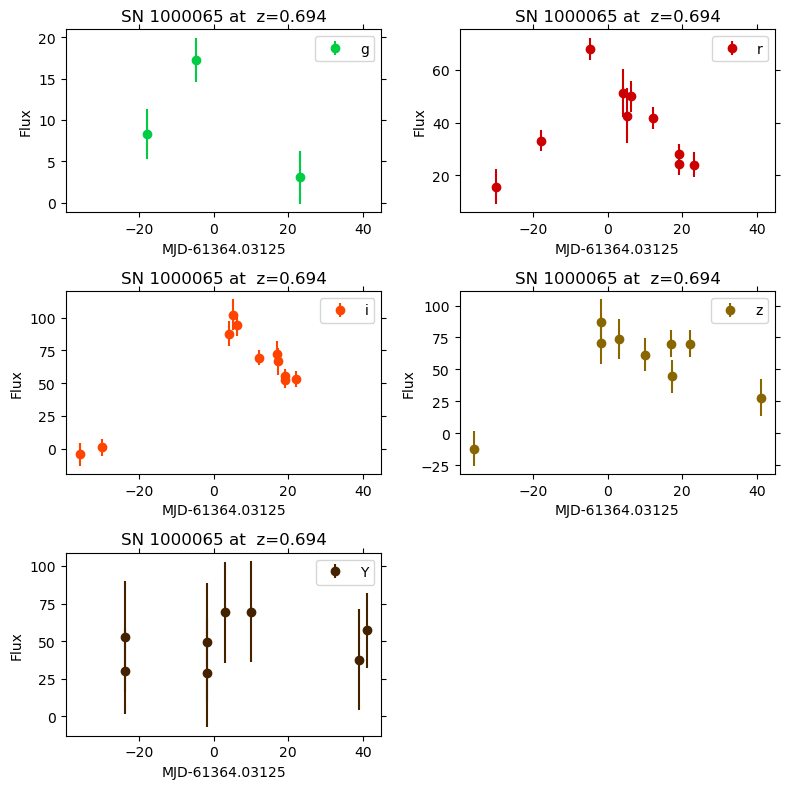

In [6]:
print( f"The first object in the list is SNID {sniadf['SNID'][0]}" )
print( f"It has a CMB-z of {sniadf['SIM_REDSHIFT_CMB'][0]}" )
mjd = sniadf['MJD'][0]
band = sniadf['BAND'][0]
fluxcal = sniadf['FLUXCAL'][0]
fluxcalerr = sniadf['FLUXCALERR'][0]
photflag = sniadf['PHOTFLAG'][0]

# Rather than just showing the detections, let's show all the forced photometry
# from 20 days before first detection to 20 days after last detection
detects = ( photflag & PHOTFLAG_DETECT ) != 0
mjdmin = mjd.filter( detects ).min() - 20
mjdmax = mjd.filter( detects ).max() + 20
toplot = ( mjd >= mjdmin ) & ( mjd <= mjdmax )

plot_ltcv( mjd.filter(toplot), band.filter(toplot), fluxcal.filter(toplot), fluxcalerr.filter(toplot),
           snid=sniadf['SNID'][0], zcmb=sniadf['SIM_REDSHIFT_CMB'][0],
           mjdoff=sniadf['PEAKMJD'][0], multiplots=True, width=8 );

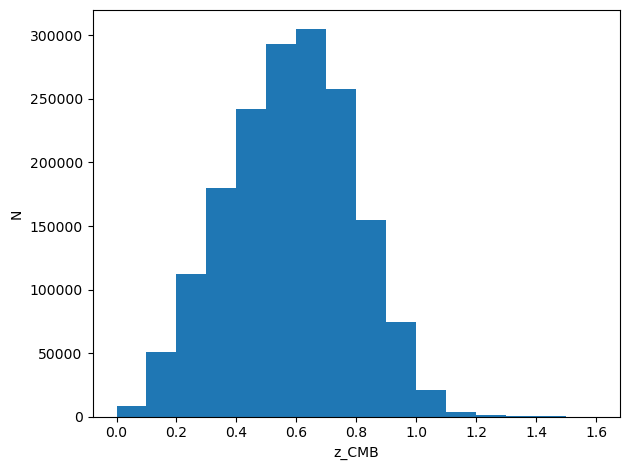

In [7]:
# Histogram of redshifts (from the truth table)
fig, axes = pyplot.subplots( 1, 1, tight_layout=True )
axes.hist( sniadf['SIM_REDSHIFT_CMB'], bins=numpy.arange( 0, 1.7, 0.1 ) )
axes.set_xlabel( r"z_CMB" )
axes.set_ylabel( r"N" )
_;